In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# Geoplots
import descartes
import geopandas as gpd 
from shapely.geometry import Point, Polygon
import geoplot as gplt
# Cluster classifications
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Linear Regression

In [4]:
# Configure plots
sns.set()
plt.rcParams['figure.figsize'] = (9,6) # size in inches 
plt.rcParams['axes.labelpad'] = 10

In [5]:
# Resulsts of linear regression
lr = pd.read_csv("data/linear_regression_results.csv").iloc[:, 1 :]

# Linear regression model
filename = "linear_regression_model.sav"
lr_model = pickle.load(open(filename, 'rb'))

# Entire data set
data = pd.read_csv("data/condos.csv")
price = data[['price']]
features = data.iloc[:, 5 :]

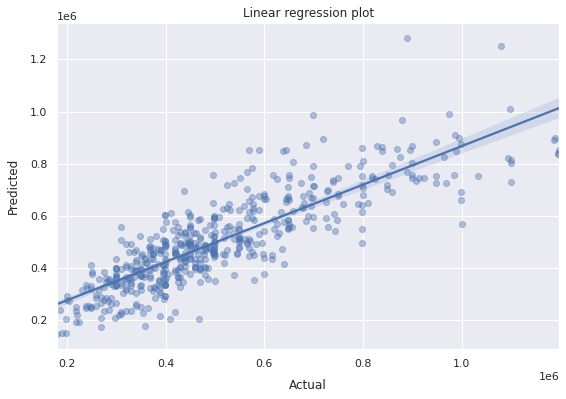

In [6]:
# Regression plot 
sns.regplot('Actual', 'Predicted', lr, scatter_kws={'alpha':0.4})
plt.title("Linear regression plot")
plt.savefig('figures/lr_plot.png', bbox_inches='tight', dpi=300)

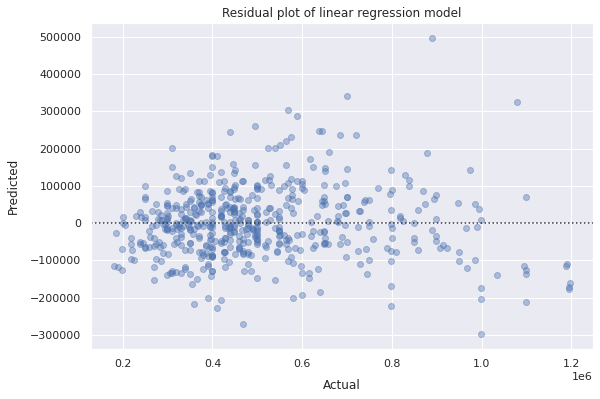

In [7]:
# Residuals plot
sns.residplot('Actual', 'Predicted', lr, scatter_kws={'alpha':0.4})
plt.title("Residual plot of linear regression model")
plt.savefig('figures/lr_residuals.png', bbox_inches='tight', dpi=300)

From the previous figures it seemed that 1.2 million dollars might be a good cutoff for the model. After this value, prediction errors increase. This is most likely because of omitted features that become more important for expensive condos such as quality of materials used for constructione.

## Predictions on entire set

In [8]:
# Price, predictinos and differences between pridicted/actual values
data_predictions = price.copy()
predictions = lr_model.predict(features)
data_predictions["predictions"] = predictions
# Differences
data_predictions["diff"] = data_predictions.price - data_predictions.predictions
# Add differences to data
data["diff"] = data_predictions["diff"]
# data_predictions sorted by differences
sorted_by_diff = data_predictions.sort_values(by="diff", ascending=False)
sorted_by_diff

,price,predictions,diff
1705,598895,2.364407e+07,-2.304518e+07
1579,629000,2.515162e+07,-2.452262e+07
1739,424000,2.546472e+07,-2.504072e+07
2622,351700,2.749820e+07,-2.714650e+07
1913,258900,4.327994e+07,-4.302104e+07
...,...,...,...
2600,889000,3.313016e+08,-3.304126e+08
877,899000,3.542838e+08,-3.533848e+08
2587,499000,3.744702e+08,-3.739712e+08
902,890000,4.076502e+08,-4.067602e+08


In [9]:
# Listings of top over-estimated condos below budget 
def top_false_estimates(budget, sorted_listings):
    """Returns indices of top 250 overestimeates below a specified budget"""
    overestimats = sorted_listings[sorted_listings["price"] <= budget]
    # Top 250
    top_indices = overestimats.head(250).index
    buttom_indices = overestimats.tail(250).index
    return (top_indices, buttom_indices)

top_false_est = top_false_estimates(budget=600000, sorted_listings=sorted_by_diff)
# Top overestimates
overestimate_indices = top_false_est[0]
top_overestimates = data.iloc[overestimate_indices, 1 :]
# Overestimate labels
top_overestimates['overestimate'] = [1 for i in range(top_overestimates.shape[0])]
top_overestimates_coordinates = data.iloc[overestimate_indices, 2 : 4]

# Top underestimates
underestimate_indices = top_false_est[1]
top_underestimate = data.iloc[underestimate_indices, 1 :]
# Underestimate labels
top_underestimate['overestimate'] = [0 for i in range(top_underestimate.shape[0])]
top_underestimate_coordinates = data.iloc[underestimate_indices, 2 : 4]

In [10]:
# Merge over and underestimates
false_estimates = pd.concat([top_overestimates, top_underestimate], axis=0)
false_estimates

,address,lat,long,price,total_area,restaurants,vibrant,cycling_friendly,historic,parks,...,greenery,year_built,unemployment_rate_2016_,bathrooms,powder_rooms,river_proximity,has_pool,has_garage,diff,overestimate
1705,"1450, boulevard René-Lévesque Ouest, apt. 1904...",45.494812,-73.573793,598895,58.0,10.0,10.0,4.0,7.0,10,...,4.0,2016.0,10,1.0,0.0,False,True,True,-2.304518e+07,1
1739,"14399, boulevard Gouin Ouest, apt. 906, Montré...",45.493214,-73.853556,424000,80.0,5.0,2.0,4.0,2.0,7,...,6.0,2012.0,8,2.0,0.0,True,False,True,-2.504072e+07,1
2622,"10438, boulevard Gouin Ouest, apt. 103, Montré...",45.510575,-73.809258,351700,99.0,5.0,2.0,5.0,0.0,7,...,3.0,2019.0,8,1.0,0.0,False,False,True,-2.714650e+07,1
1913,"1000, Rue Ottawa, apt. 405, Montréal (Le Sud-O...",45.494718,-73.558671,258900,234.0,10.0,9.0,10.0,6.0,10,...,3.0,2014.0,8,1.0,0.0,False,True,False,-4.302104e+07,1
1751,"1000, Rue Ottawa, apt. 432, Montréal (Le Sud-O...",45.494718,-73.558671,265000,238.0,10.0,9.0,10.0,6.0,10,...,3.0,2014.0,8,1.0,0.0,False,True,False,-4.346586e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,"1163, Croissant du Collège, apt. 7, Montréal (...",45.437499,-73.603150,415000,1873.0,5.0,2.0,6.0,0.0,8,...,6.0,1987.0,10,1.0,0.0,False,False,False,-2.267214e+08,0
2454,"3444 - 3446, Rue Saint-Hubert, Montréal (Le Pl...",45.519386,-73.567657,585000,1912.0,10.0,10.0,10.0,7.0,10,...,6.0,1980.0,8,2.0,0.0,False,False,False,-2.316341e+08,0
505,"2251, Avenue Girouard, Montréal (Côte-des-Neig...",45.472233,-73.610935,459000,1951.0,9.0,7.0,3.0,6.0,9,...,6.0,1930.0,11,2.0,0.0,False,False,True,-2.357143e+08,0
2270,"1927, Avenue Prud'homme, Montréal (Côte-des-Ne...",45.471761,-73.605386,444000,2317.0,9.0,5.0,4.0,5.0,9,...,6.0,1910.0,11,1.0,0.0,False,False,False,-2.766165e+08,0


## Geo-Visualization of Top Listings

In [20]:
# Montreal road map from shapefile
street_map = gpd.read_file("montreal_shape/roads.shp")

In [21]:
# coordinate reference system
crs = {'init': 'epsg:4326'}
geometry = [Point(x,y) for x, y in zip(false_estimates['long'], false_estimates['lat'])]
geometry[: 3]

In [22]:
# Initialize geo data frame
geo_df = gpd.GeoDataFrame(false_estimates, crs=crs, geometry=geometry)
geo_df.tail()

,address,lat,long,price,total_area,restaurants,vibrant,cycling_friendly,historic,parks,...,year_built,unemployment_rate_2016_,bathrooms,powder_rooms,river_proximity,has_pool,has_garage,diff,overestimate,geometry
664,"1163, Croissant du Collège, apt. 7, Montréal (...",45.437499,-73.603150,415000,1873.0,5.0,2.0,6.0,0.0,8,...,1987.0,10,1.0,0.0,False,False,False,-2.267214e+08,0,POINT (-73.60315 45.43750)
2454,"3444 - 3446, Rue Saint-Hubert, Montréal (Le Pl...",45.519386,-73.567657,585000,1912.0,10.0,10.0,10.0,7.0,10,...,1980.0,8,2.0,0.0,False,False,False,-2.316341e+08,0,POINT (-73.56766 45.51939)
505,"2251, Avenue Girouard, Montréal (Côte-des-Neig...",45.472233,-73.610935,459000,1951.0,9.0,7.0,3.0,6.0,9,...,1930.0,11,2.0,0.0,False,False,True,-2.357143e+08,0,POINT (-73.61093 45.47223)
2270,"1927, Avenue Prud'homme, Montréal (Côte-des-Ne...",45.471761,-73.605386,444000,2317.0,9.0,5.0,4.0,5.0,9,...,1910.0,11,1.0,0.0,False,False,False,-2.766165e+08,0,POINT (-73.60539 45.47176)
2587,"7312, Rue Sherbrooke Ouest, Montréal (Côte-des...",45.456370,-73.640349,499000,3181.0,7.0,4.0,6.0,4.0,8,...,1924.0,11,3.0,1.0,False,False,False,-3.739712e+08,0,POINT (-73.64035 45.45637)


In [23]:
# Plot geo data frame
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df.overestimate == 1].plot(ax=ax, markersize=20, color='blue', marker='o', label='Overestimate')
geo_df[geo_df.overestimate == 0].plot(ax=ax, markersize=20, color='red', marker='^', label='Underestimate')
plt.title("Top 250 over and under estimated Montreal real estate listings below $600K")
plt.legend()
plt.savefig('figures/lr_underAndOverestimates.png', bbox_inches='tight', dpi=300)
plt.close() # to decrease size of notebook

Next, we will implement a color gradient based on the `diff` feature in `sorted_by_diff`. Colors that stand out in particular regions that are dominated by colors at the opposite end of the scale might be of interest for investors.

In [24]:
# New geometry
geometry = [Point(x,y) for x, y in zip(data['long'], data['lat'])]
# New geo data frame
geo_df = gpd.GeoDataFrame(data, crs=crs, geometry=geometry).iloc[:, 1 :]
geo_df.tail()

,address,lat,long,price,total_area,restaurants,vibrant,cycling_friendly,historic,parks,...,greenery,year_built,unemployment_rate_2016_,bathrooms,powder_rooms,river_proximity,has_pool,has_garage,diff,geometry
2673,"160, Rue Khalil-Gibran, apt. 401, Montréal (Sa...",45.527889,-73.667478,650000,1537.0,7.0,4.0,3.0,0.0,8,...,4.0,2010.0,10,2.0,0.0,False,True,True,-1.891413e+08,POINT (-73.66748 45.52789)
2674,"4500, Chemin de la Côte-des-Neiges, apt. 701, ...",45.495407,-73.606735,279000,552.0,10.0,5.0,8.0,4.0,10,...,6.0,2012.0,11,1.0,0.0,False,False,True,-7.868113e+07,POINT (-73.60674 45.49541)
2675,"2301, Rue Saint-Patrick, apt. B509, Montréal (...",45.481674,-73.569046,599000,808.0,10.0,7.0,10.0,6.0,10,...,5.0,2015.0,8,1.0,0.0,False,False,False,-1.073224e+08,POINT (-73.56905 45.48167)
2676,"2301, Rue Saint-Patrick, apt. B215, Montréal (...",45.481674,-73.569046,1050000,1390.0,10.0,7.0,10.0,6.0,10,...,5.0,2015.0,8,2.0,0.0,False,False,True,-1.725621e+08,POINT (-73.56905 45.48167)
2677,"2365, Rue Saint-Patrick, apt. 602A, Montréal (...",45.481674,-73.569046,1100000,1218.0,10.0,7.0,10.0,6.0,10,...,5.0,2015.0,8,2.0,0.0,False,False,True,-1.531226e+08,POINT (-73.56905 45.48167)


In [25]:
# Color pallette
# cmap = sns.cubehelix_palette(as_cmap="True", dark=0.1, light=0.95)
cmap = sns.color_palette("viridis", as_cmap=True)

In [26]:
# Plot geo data frame
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.2, color='grey')
#geo_df.plot(ax=ax, c=geo_df["diff"], cmap=cmap, markersize=5, marker='o', legend=True)
gplt.pointplot(geo_df, ax=ax, hue="diff", cmap=cmap, legend=True)
plt.title("Mapped differences between actual and predicted prices")
plt.savefig('figures/lr_mappedAccuracies.png', bbox_inches='tight', dpi=300)
plt.close() # to decrease size of notebook

## Cluster Neighbourhood Data

In this section we will first reduce the number of neighbourhood features using PCA. This will increase the performance of Kmeans which will be applied to the transformed data to aggregate and label each record. The labels will then be used to gether with geographical coordinates to visualize different types of neighbourhoods. Further analysis may reveal dominant neighbourhood patterns that correlate well with other features. Most interesting would be a correlation to the `population_variation_between_2011_2016_` feature. A similar analysis will be performed on the demographic data to identify `up-and-coming neighbourhoods`. 

In [59]:
data.columns

Index(['Unnamed: 0', 'index', 'title', 'address', 'price', 'lat', 'long',
       'restaurants', 'shopping', 'vibrant', 'cycling_friendly',
       'car_friendly', 'historic', 'quiet', 'elementary_schools',
       'high_schools', 'parks', 'nightlife', 'groceries', 'daycares',
       'pedestrian_friendly', 'cafes', 'transit_friendly', 'greenery',
       'year_built', 'population_variation_between_2011_2016_',
       'population_density_', 'unemployment_rate_2016_',
       'less_than_$50,000_(%)', 'between_$50,000_and_$80,000_(%)',
       'between_$80,000_and_$100,000_(%)', 'between_$100,000_and_$150,000_(%)',
       '1-person_households_(%)', '2-person_households_(%)',
       '3-person_households_(%)', '4-person_households_(%)',
       'couples_without_children_at_home_(%)',
       'couples_with_children_at_home_(%)', 'owners_(%)', 'before_1960_(%)',
       'between_1961_and_1980_(%)', 'between_1981_and_1990_(%)',
       'between_1991_and_2000_(%)', 'between_2001_and_2010_(%)',
       'si

In [32]:
data = pd.read_csv("data/condos.csv")

In [56]:
neighbourhood_data = ['restaurants',
       'shopping', 'vibrant', 'cycling_friendly', 'car_friendly', 'historic',
       'quiet', 'elementary_schools', 'high_schools', 'parks', 'nightlife',
       'groceries', 'daycares', 'pedestrian_friendly', 'cafes',
       'transit_friendly', 'greenery']

# Slice neighbourhood and demographic data 
neighbourhoods = data[neighbourhood_data]
# Standardize data
x = StandardScaler().fit_transform(neighbourhoods)

# PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_
print(explained_variance)

[9.52021571 1.91409846 1.44366356 0.74696719 0.58740633 0.54607657
 0.51963175 0.46129783 0.37616865 0.24020734 0.22843392 0.15096371
 0.09878231 0.07318946 0.04929958 0.02823316 0.02171487]


In [49]:
# PCA
pca = PCA(n_components=2)
pca_transform = pca.fit_transform(x)

# K-means
k_means = KMeans(n_clusters=5)
k_means.fit(pca_transform)

KMeans(n_clusters=5)

In [50]:
axis_1 = pca_transform[:, 0]
axis_2 = pca_transform[:, 1]

Text(0, 0.5, 'PCA2')

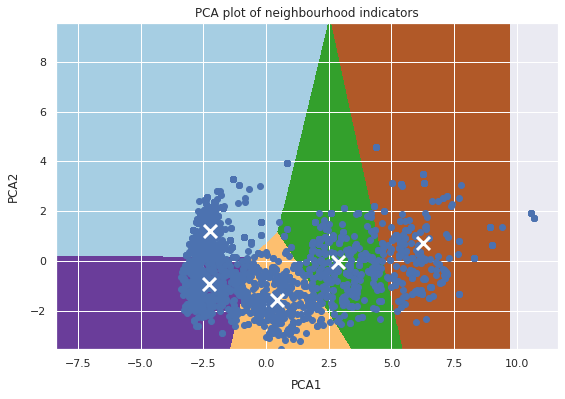

In [55]:
# PCA plot indicating Kmeans clusters
x_min, x_max = pca_transform[:, 0].min() - 5, pca_transform[:, 0].max() - 1
y_min, y_max = pca_transform[:, 1].min(), pca_transform[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')
plt.scatter(axis_1, axis_2)
centroids = k_means.cluster_centers_
inert = k_means.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.title("PCA plot of neighbourhood indicators")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

In [52]:
print(abs( pca.components_ )[0])

[0.3101042  0.29842406 0.30735745 0.10337072 0.27297753 0.28164642
 0.15936432 0.11169115 0.1463906  0.22352887 0.29638288 0.25095667
 0.17710389 0.29001976 0.30389885 0.29447187 0.03388446]


Top neighbourhood indicators according to PCA1 components: `'restaurants', 'shopping', 'vibrant', 'nightlife','pedestrian_friendly', 'cafes', 'transit_friendly'`. 
 
This likely differentiates downtown areas from suburbs. Next we will increase the number of PCAs so that at least 80% of the variance is explained. We will then use Kmeans to cluser and label data.

In [48]:
below_80 = False
i = 0
percent_var = 0

# Find number of PCs to explain 80% variance
while below_80 == False:
    total_variance = sum(explained_variance)
    percent_var += 100*(explained_variance[i]/total_variance)
    i += 1
    if percent_var >= 80:
        below_80 = True
print("Number of PCs to explain 80% of variance:", i)
print("Variance explained by {} PCs".format(i), percent_var, "%")

Number of PCs to explain 80% of variance: 4
Variance explained by 4 PCs 80.11680696319559 %


## Cluster Demographic Data

In [58]:
demographic_data = ['less_than_$50,000_(%)', 'between_$50,000_and_$80,000_(%)',
       'between_$80,000_and_$100,000_(%)', 'between_$100,000_and_$150,000_(%)',
       '1-person_households_(%)', '2-person_households_(%)',
       '3-person_households_(%)', '4-person_households_(%)',
       'couples_without_children_at_home_(%)',
       'couples_with_children_at_home_(%)', 'owners_(%)', 'before_1960_(%)',
       'between_1961_and_1980_(%)', 'between_1981_and_1990_(%)',
       'between_1991_and_2000_(%)', 'between_2001_and_2010_(%)',
       'single-family_homes_(%)', 'semi-detached_or_row_houses_(%)',
       'buildings_with_less_than_5_floors_(%)',
       'buildings_with_5_or_more_floors_(%)', 'university_(%)', 'college_(%)',
       'secondary_(high)_school_(%)', 'apprentice_or_trade_school_diploma_(%)',
       'non-immigrant_population_(%)', 'french_(%)', 'english_(%)']
# Slice neighbourhood and demographic data 
neighbourhoods = data[neighbourhood_data]
demographics = data[demographic_data]